In [1]:
import os
repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import geopandas as gpd
import shapely
import fiona

from affine import Affine

import pandas as pd
import rasterio
import rasterio.mask
from rasterio import warp

import warnings

from nl_helpers import (apply_polygon_mask_and_return_flat_array, 
                        correct_nl_df_creation, bins,create_nl_binned_dataframe)

## Creation of NL features for ADM1, ADM2, and DHS Cluster Polygons

NL Data: https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html

We are going to use `Average Visible, Stable Lights, & Cloud Free Coverages` for the most recent year, 2013. 

The download URL is here: `https://ngdc.noaa.gov/eog/data/web_data/v4composites/F182013.v4.tar`

### README information:
Version 4 DMSP-OLS Nighttime Lights Time Series

    The files are cloud-free composites made using all the available
    archived DMSP-OLS smooth resolution data for calendar years. In cases
    where two satellites were collecting data - two composites were produced.
    The products are 30 arc second grids, spanning -180 to 180 degrees
    longitude and -65 to 75 degrees latitude. A number of constraints are
    used to select the highest quality data for entry into the composites:

      * Data are from the center half of the 3000 km wide OLS swaths.
        Lights in the center half have better geolocation, are smaller,
        and have more consistent radiometry.

      * Sunlit data are excluded based on the solar elevation angle.

      * Glare is excluded based on solar elevation angle.

      * Moonlit data are excluded based on a calculation of lunar
        illuminance.

      * Observations with clouds are excluded based on clouds
        identified with the OLS thermal band data and NCEP surface
        temperature grids.
        
      * Lighting features from the aurora have been excluded in the
        northern hemisphere on an orbit-by-orbit manner using visual
        inspection.

    Each composite set is named with the satellite and the year (F121995 is
    from DMSP satellite number F12 for the year 1995). Three image types are
    available as geotiffs for download from the version 4 composites:


    F1?YYYY_v4b_cf_cvg.tif: Cloud-free coverages tally the total
    number of observations that went into each 30 arc second grid cell. This
    image can be used to identify areas with low numbers of observations
    where the quality is reduced. In some years there are areas with zero
    cloud- free observations in certain locations.


    F1?YYYY_v4b_avg_vis.tif: Raw avg_vis contains the average of the
    visible band digital number values with no further filtering. Data
    values range from 0-63. Areas with zero cloud-free observations are
    represented by the value 255.


    F1?YYYY_v4b_stable_lights.avg_vis.tif: The cleaned up avg_vis
    contains the lights from cities, towns, and other sites with persistent
    lighting, including gas flares. Ephemeral events, such as fires have
    been discarded. Then the background noise was identified and replaced
    with values of zero. Data values range from 1-63. Areas with zero
    cloud-free observations are represented by the value 255.
    
    NOTE:  The OLS has no on-board calibration and the gain settings are not
    recorded in the data stream.  While the time-series of annual cloud-free
    composites were produced using the same algorithms and a stringent data
    selection criteria, the digital number (DN) values are not strictly
    comparable from one year to the next.  We recommend users perform an
    intercalibration prior to direct comparison of the DN values across the
    time series.  For discussion on these points contact chris.elvidge@noaa.gov.


We will use the more heavily processed stable nights product

### Read raw nl raster
Data downloaded from link above

In [7]:
# directory = data_dir + "raw/DMSP_NL/"
# file = "F182013.v4c_web.stable_lights.avg_vis.tif"

# src = rasterio.open(directory+file)

# arr = src.read(1)
# arr = arr.astype(np.float64)

#### Write an intermediate raster object where values have been converted to floats

In [8]:
outpath = (data_dir + "int/DMSP_NL/"
           "F182013.v4c_web.stable_lights.avg_vis_converted_to_np-float.tif")

# out_meta = src.meta.copy()
# out_meta["dtype"] = np.float64

# out_meta
# with rasterio.open(outpath , "w", **out_meta) as dest:
#     dest.write(np.array([arr]))

###  Read in this new raster -- works better in pipeline

In [9]:
src = rasterio.open(outpath)

### Read shapefile for ADM1 polygons

Shapefile downloaded from Global Data Lab. Basic pre-processing occured in the `HDI_label_creation.ipynb` notebook.

In [5]:
gpdf = pd.read_pickle(data_dir + "int/GDL_HDI/HDI_ADM1_shapefile_clean.p")

In [6]:
gpdf.head()

,constant,iso_code,country,region,shdi,geometry
GDLCODE,,,,,,
ANDt,World,AND,Andorra,Total,0.857458,"POLYGON ((1.56324 42.45882, 1.56120 42.45871, ..."
AREt,World,ARE,United Arab Emirates,Total,0.866315,"MULTIPOLYGON (((52.44715 24.11619, 52.44718 24..."
ATGt,World,ATG,Antigua and Barbuda,Total,0.777000,"MULTIPOLYGON (((-62.34514 16.94514, -62.34514 ..."
BHRt,World,None,None,None,NaN,"MULTIPOLYGON (((50.73292 25.56236, 50.73292 25..."
BHSt,World,BHS,Bahamas,Total,0.805146,"MULTIPOLYGON (((-72.99986 20.99986, -73.00014 ..."


### Example usage of apply polygon mask function

array([ 7., 12.,  8., ...,  0.,  5.,  5.])

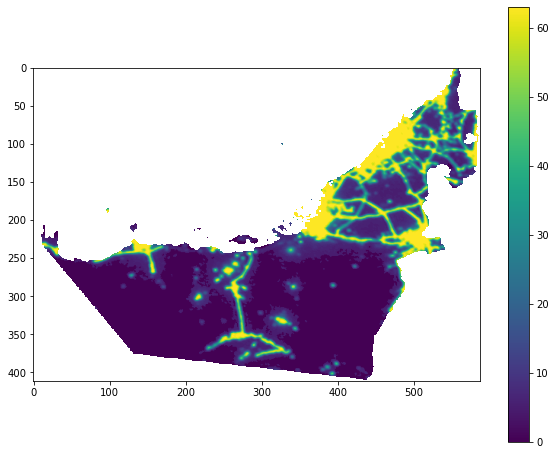

In [7]:
apply_polygon_mask_and_return_flat_array(gpdf.loc["AREt", "geometry"], raster_file=src, plot=True)

## Create binned histogram nl features

These nl features are done without population weighting. We will add population weighting later on.

### First let's make the features for GDL ADM1 polygons

In [9]:
out = create_nl_binned_dataframe(gpdf, raster_file=src)

## This line of code assigns a nearest tile to polygons that do not contain an nl centroid
out = correct_nl_df_creation(out, gpdf, src)

out.to_pickle(data_dir + "features/nl_features/GDL_HDI_polygons/dmsp_nightlight_features_for_hdi_polygons_20_bins.p")


Num missing =  0


### Now doing binned hist version for ADM0

In [2]:
country_path = data_dir + "int/GDL_HDI/HDI_ADM1_shapefile_clean.p"
country_shps = pd.read_pickle(country_path)

In [10]:
out = create_nl_binned_dataframe(country_shps, raster_file = src)

## This line of code assigns a nearest tile to polygons that do not contain an nl centroid
out = correct_nl_df_creation(out, country_shps, src)
out.to_pickle(data_dir + "features/nl_features/GDL_ADM0_polygons/dmsp_nightlight_features_for_adm0_polygons_20_bins.p")


Num missing =  0


### Now we repeat binned histogram again for DHS polygons

In [13]:
dhs_shp = pd.read_pickle(data_dir+"int/GDL_IWI/DHS_iwi_cluster_buffers_clipped.p").set_index("DHSID")

In [14]:
out = create_nl_binned_dataframe(dhs_shp, raster_file=src)

## This line of code assigns a nearest tile to polygons that do not contain an nl centroid
out = correct_nl_df_creation(out, dhs_shp, src)
out.to_pickle(data_dir + "features/nl_features/DHS_polygons/dmsp_nightlight_features_for_iwi_polygons_20_bins.p")


/home/lsherman/miniconda3/envs/maps-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Num missing =  5


### Finally, we repeat for ADM2 regions

In [19]:
file = data_dir + "raw/geoBoundaries/geoBoundariesCGAZ_ADM2.geojson"
adm2 = gpd.read_file(file).set_index("shapeID")

In [20]:
out = create_nl_binned_dataframe(adm2, raster_file=src)

## This line of code assigns a nearest tile to polygons that do not contain an nl centroid
out = correct_nl_df_creation(out, adm2, src)
out.to_pickle(data_dir + "features/nl_features/geoBoundaries_ADM2/dmsp_nightlight_features_for_geoboundaries_ADM2_polygons_20_bins.p")


/home/lsherman/miniconda3/envs/maps-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Num missing =  7057
